In [43]:
import tensorflow as tf
import numpy as np
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import wispy.waveutils
import phenom

In [6]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [7]:
training_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/training_data")

In [8]:
validation_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/validation_data")

In [9]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

# load models and compare 

In [10]:
amplitude_model_sub_clone = tf.keras.models.load_model("deep_autoencoder_amplitude_model.h5", compile=False)
phase_model_sub_clone = tf.keras.models.load_model("deep_autoencoder_phase_model.h5", compile=False)

In [18]:
def predict_wave(base_model, index, scale_data=True):
    
    mask = training_data['mask'][base_model]
    
    amp = amplitude_model_sub_clone.predict(training_data['amplitude'][mask])[1][index]
    phase = phase_model_sub_clone.predict(training_data['phase'][mask])[1][index]
    
    times = training_data['times']
    this_index = training_data['mask'][base_model][index]
    q = training_data['mass_ratios'][this_index]
    eta = phenom.eta_from_q(q)
    
    if scale_data:
        tc = training_data['data_processing_params']['tc']
        t3_leading = wispy.waveutils.taylorT3_leading_term(times, eta, tc)
        phase = phase * t3_leading
        phase_scale = training_data['data_processing_params']['phase_scale']
        phase = phase * phase_scale

        amp_scale = training_data['data_processing_params']['amp_scale']
        amp = amp * amp_scale * eta
    
    
    h = amp * np.exp(-1.j*phase)
#     return np.real(h)
    return h, amp, phase

In [19]:
# predict_wave('IMRPhenomD', 50)

In [28]:
def compare_with_truth(base_model, index, plot=True, scale_data=True):
    times = training_data['times']
    this_index = training_data['mask'][base_model][index]
    
    q = training_data['mass_ratios'][this_index]
    eta = phenom.eta_from_q(q)
    ground_truth_amp = training_data['amplitude'][this_index]
    ground_truth_phase = training_data['phase'][this_index]
    
    if scale_data:
        ground_truth_amp = ground_truth_amp*training_data['data_processing_params']['amp_scale']*phenom.eta_from_q(q)
        tc = training_data['data_processing_params']['tc']
        t3_leading = wispy.waveutils.taylorT3_leading_term(times, eta, tc)
        phase_scale = training_data['data_processing_params']['phase_scale']
        ground_truth_phase = ground_truth_phase * phase_scale * t3_leading 

    ground_truth_h = ground_truth_amp * np.exp(-1.j*ground_truth_phase)
    
    model_h, model_amp, model_phase = predict_wave(base_model, index, scale_data=scale_data)
    
    if plot:
        plt.figure(figsize=(18, 18))
        plt.subplot(3, 2, 1)
        plt.plot(times, np.real(ground_truth_h), label=f'{base_model}')
        plt.plot(times, np.real(model_h), ls='--', label='model')
    #     plt.xlim(-100, 75)
        plt.legend()

        plt.subplot(3, 2, 3)
        plt.plot(times, ground_truth_amp)
        plt.plot(times, model_amp, ls='--')
    #     plt.xlim(-100, 75)
    #     plt.yscale('log')

        plt.subplot(3, 2, 4)
        plt.plot(times, ground_truth_amp-model_amp)
        plt.title('amp')

        plt.subplot(3, 2, 5)
        plt.plot(times, ground_truth_phase)
        plt.plot(times, model_phase, ls='--')
    #     plt.xlim(-100, 75)

        plt.subplot(3, 2, 6)
        plt.plot(times, ground_truth_phase-model_phase)
        plt.title('phase')

        plt.suptitle(f"base_model: {base_model}, mass-ratio: {q}")


        plt.show()
        plt.close()

    else:
        return ground_truth_h, ground_truth_amp, ground_truth_phase, model_h, model_amp, model_phase

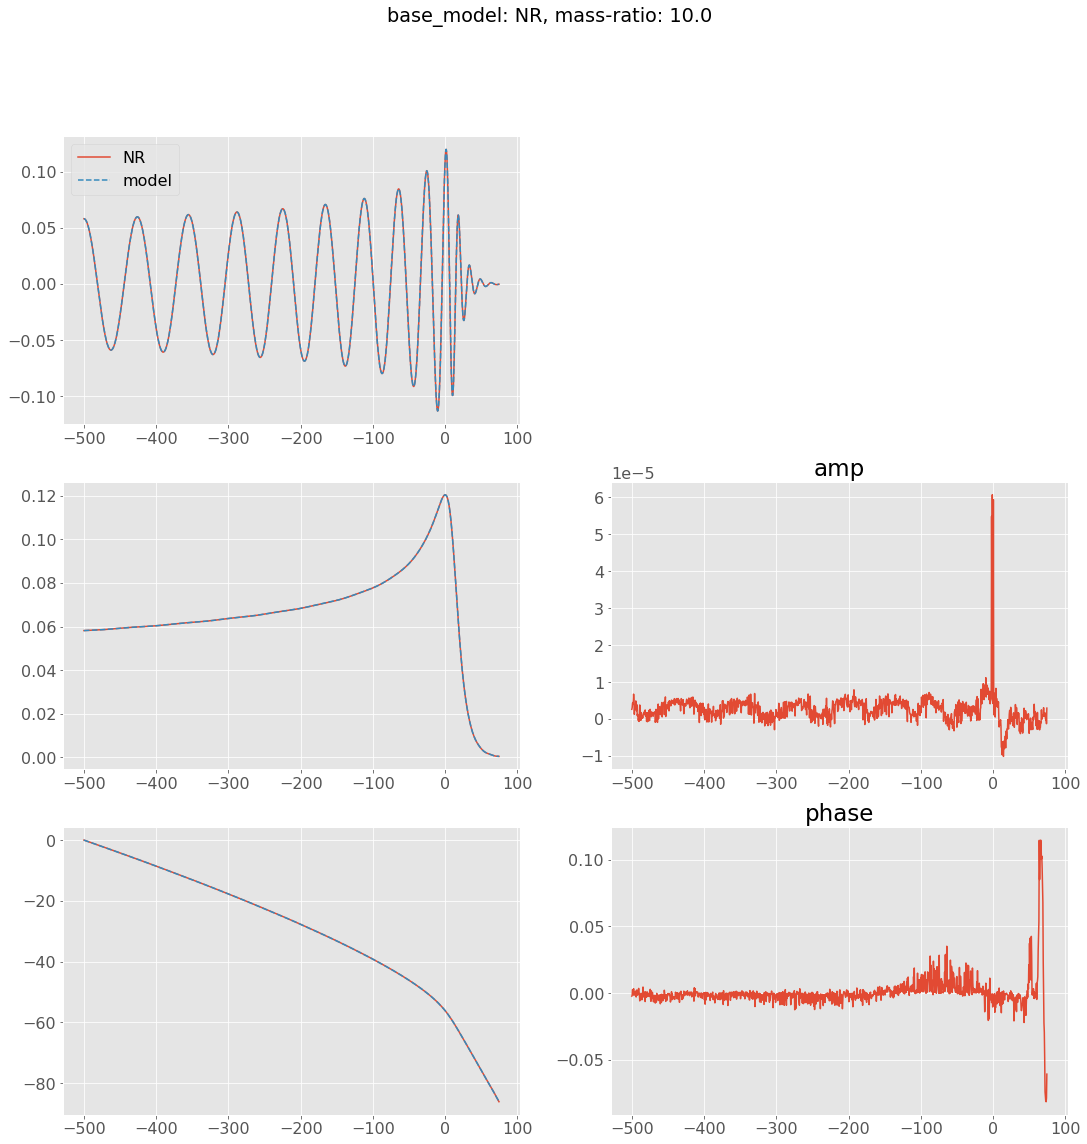

In [30]:
compare_with_truth("NR", -1, scale_data=True)
# compare_with_truth("IMRPhenomD", -1, scale_data=True)
# compare_with_truth("SEOBNRv4_opt", -1, scale_data=False)

In [51]:
index = -1
ground_truth_h = {}
ground_truth_amp = {}
ground_truth_phase = {}
model_h = {}
model_amp = {}
model_phase = {}
for base_model in training_data['unique_approximants']:
    ground_truth_h[base_model], ground_truth_amp[base_model], ground_truth_phase[base_model], model_h[base_model], model_amp[base_model], model_phase[base_model] = compare_with_truth(base_model, index, plot=False, scale_data=True)

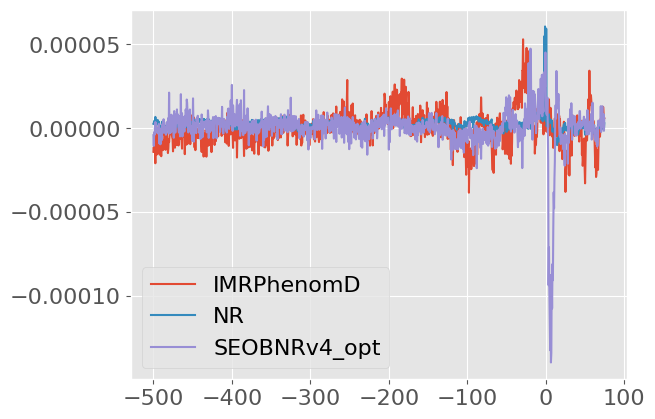

In [54]:
times = training_data['times']
plt.figure()
for base_name in ground_truth_amp.keys():
    plt.plot(times, ground_truth_amp[base_name]-model_amp[base_name], label=base_name)
#     plt.plot(times, , ls='--')
#     plt.title(base_name)
# plt.xlim(-100, 10)
plt.legend()
plt.show()
plt.close()

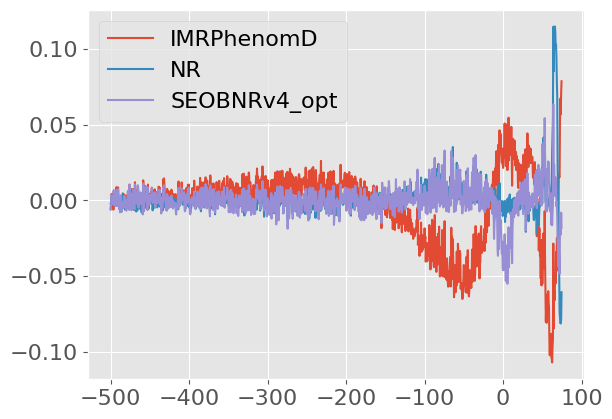

In [55]:
times = training_data['times']
plt.figure()
for base_name in ground_truth_amp.keys():
    plt.plot(times, ground_truth_phase[base_name]-model_phase[base_name], label=base_name)
#     plt.plot(times, , ls='--')
#     plt.title(base_name)
# plt.xlim(-100, 10)
plt.legend()
plt.show()
plt.close()

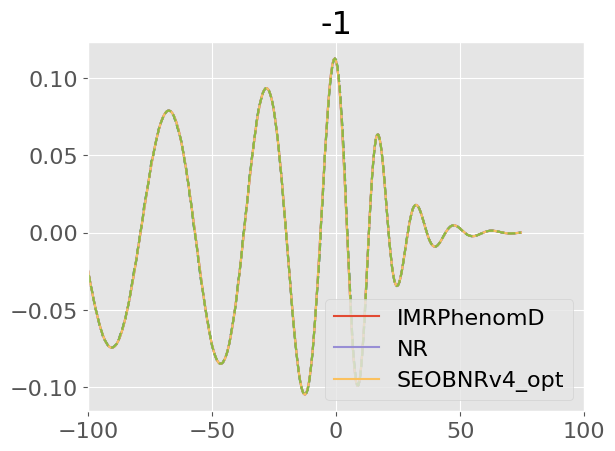

In [56]:
times = training_data['times']
plt.figure()
for base_name in ground_truth_amp.keys():
    plt.plot(times, np.real(ground_truth_h[base_model]), label=base_name)
    plt.plot(times, np.real(model_h[base_model]), ls='--')
    plt.title(index)
plt.xlim(-100, 100)
plt.legend()
plt.show()
plt.close()